# Finding line lanes on the road in images and videos

In this project I've used python to find the lanes in images and video. To do this I've collected sample images and videos. The first thing is to import the useful libraries. I've added some of the libraries later since they are not useful intitially but later found their use.

In [8]:
#importing some useful libraries
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import math
import os
from moviepy.editor import VideoFileClip
from IPython.display import HTML
%matplotlib inline

Steps for finding lanes for any image of road includes reading that particular image, color selection, canny edge detection and Hough transform. For color selection I've converted the image into gray scale image. I've also applied gaussian smaoothing just to smoothen the image.
Before trying on videos I've implemented the tools on images for a clarity.

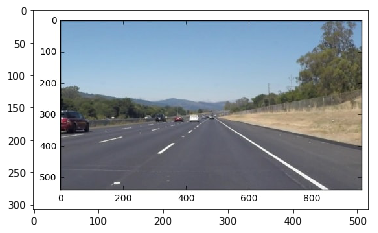

In [9]:
#reading the image
image = mpimg.imread('testimages/solidWhiteRight.jpg')
plt.imshow(image)

In [13]:
#defining
def grayscale(img):
    return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_noise(img, kernel_size):
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    mask = np.zeros_like(img)   
    if len(img.shape) > 2:
        channel_count = img.shape[2]  
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon     
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image 
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


def draw_lines(img, lines, color=[255, 0, 0], thickness=10):
    for line in lines:
        for x1,y1,x2,y2 in line:
            cv2.line(img, (x1, y1), (x2, y2), color, thickness)

def hough_lines(img, initial_img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros(initial_img.shape, dtype=np.uint8)
    draw_lines(line_img, lines)
    return line_img

def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    return cv2.addWeighted(initial_img, α, img, β, λ)


In [12]:
def process_image(image):
    #calling
    #Reading and converting into grayscale image
    gray = grayscale(image)

    #Applying Gaussian smoothing
    kernel_size = 7
    blur_gray = gaussian_noise(gray, kernel_size)

    #Canny edge detection 
    low_threshold = 50
    high_threshold = 150
    edges = canny(blur_gray, low_threshold, high_threshold) 

    #region to be selected for masking and it is a polygon
    imshape = image.shape
    vertices = np.array([[(100,imshape[0]), (440, 325), (550, 325), (imshape[1],imshape[0])]], dtype=np.int32)
    masked_edges = region_of_interest(edges, vertices)

    #defining Hough transform parameters
    rho = 2 
    theta = np.pi/360 
    threshold = 20     
    min_line_len = 120 
    max_line_gap = 80   
    #Applying hough transform on edge detected image 
    line_image = hough_lines(masked_edges, image, rho, theta, threshold, min_line_len, max_line_gap)

    #drawing the lines on the edge image
    result = weighted_img(line_image, image)
    return result

Now its time to test on images in the folder testimages

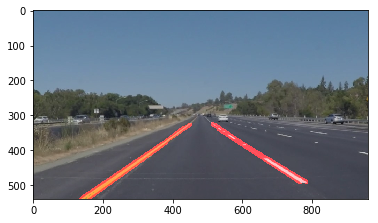

In [15]:
#For images
image = mpimg.imread('testimages/solidYellowLeft.jpg')
plt.imshow(process_image(image))

Thats the expected and clear output for an image but we are looking same sort of output for a given input video. For this we need to import special libraries which I've included in the libraries cell. I've considered a video as a test video 

In [16]:
#for videos
yellow_output = 'yellow.mp4'
clip1 = VideoFileClip('solidYellowLeft.mp4')
yellow_clip = clip1.fl_image(process_image)
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

It's nice to see the cool output. But when I observed deeply, my piece of code will not be robust for some camera angles and this algorithm can be further modified for robustness.
one more thing that I figured is, this developed algorithm may not work for steep roads(up/down). For this my solution is to figure a horizontal road where the sky and the road meets and then implement the algorithm.